# Data Preprocessing

## Import Packages and Set Up Environment

### Import Core Packages

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil

### Get Current Operating System and Set Paths Dependent on Working OS

In [7]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()

if cur_system == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path

    # Directories for current working session. These need to be set manually.
    basepath = os.getcwd()
    # If notebook is remote
    # basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024-07-22_WaterTrainingTrack1')

    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing/Plots')

elif cur_system == "Windows":   # For Windows
    sys.path.extend(['C:\\BrianKim\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    
    # Directories for current working session. These need to be set manually.
    #basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1')
    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots')

### Import NeuroPy Packages

In [8]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData

from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

from neuropy.io.neuroscopeio import NeuroscopeIO

### Import Session Data

In [9]:
session_name = 'Stb_Silverstone'

sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3405.69 seconds 
duration: 0.95 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

Buffer of 0.25 added before/after each epoch
/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.art_epochs.npy saved
Total artifact time = 19.8 seconds
Automatically detected artifact epochs:
       start       stop label  duration
0   293.2620   294.1556          0.8936
1   718.4604   722.6820          4.2216
2  1782.3484  1783.1148          0.7664
3  2680.8996  2685.2980          4.3984
4  2691.7812  2699.9724          8.1912
5  2706.2932  2706.8060          0.5128
6  2731.9692  2732.7932          0.8240


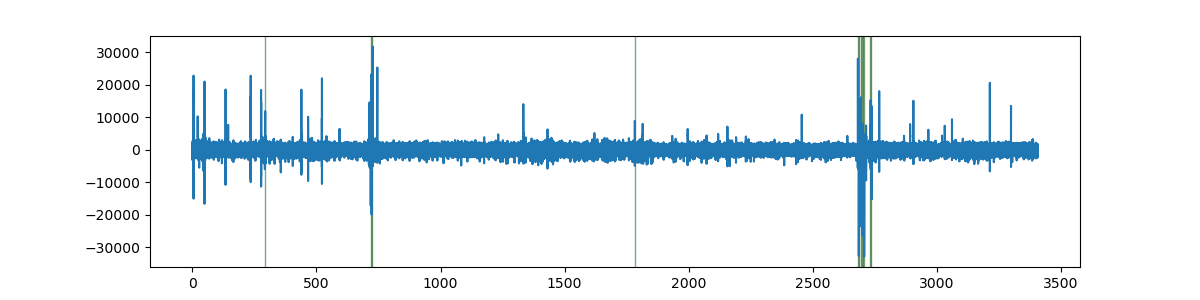

In [6]:
%matplotlib widget

# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 12     # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6        # Merges epochs that are too close to each other
rewrite = True

# Get signal object
signal = sess.eegfile.get_signal()

# Find artifact epochs. If file exists already, load that instead of creating a new file.

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")

if rewrite == False:
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('WARNING: Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, 
                                            merge=art_merge)
    # Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
    if buffer_add is not None:
        art_epochs.add_epoch_buffer(buffer_add)

    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    ns_art_file = basepath + '/' + session_name + '.evt.art'
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

# Plot artifact onto an example channel
chan_plot = 15 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection

/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.art_epochs.npy saved
Total artifact time = 20.5 seconds
Automatically detected artifact epochs:
       start       stop label  duration
0   276.9158   277.6118          0.6960
1   293.2622   294.1556          0.8934
2   718.4604   722.6822          4.2218
3  1782.3484  1783.1148          0.7664
4  2680.8996  2685.2982          4.3986
5  2691.7812  2699.9724          8.1912
6  2706.2932  2706.8062          0.5130
7  2731.9692  2732.7932          0.8240


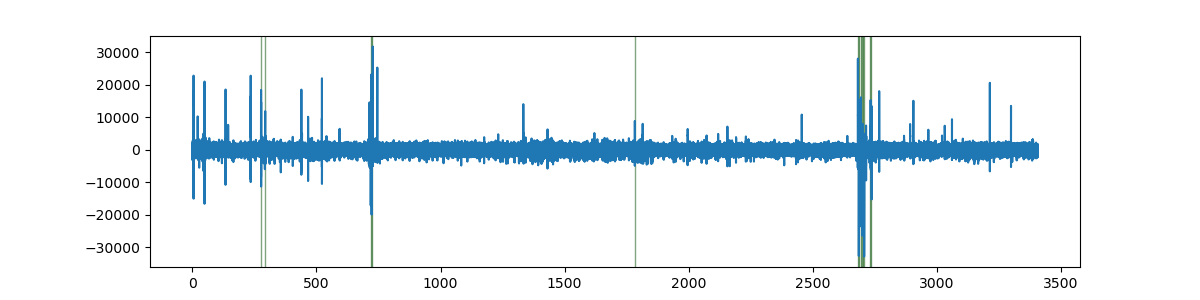

In [19]:
art_epochs = sess.recinfo.event_to_epochs(ns_art_file)
art_epochs.save(art_epochs_file)
print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

# Plot artifact onto an example channel
chan_plot = 15 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)
art_fig_name = f'{session_name}_Artifacts_Channel{chan_plot}.png' 
plt.savefig(plot_dir / art_fig_name, dpi=300, bbox_inches='tight')  # Save with full path

### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [20]:
SR = sess.recinfo.dat_sampling_rate

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)

stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_art_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")

stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / SR, 
    "stop": stim_off_events.reset_index(drop=True) / SR, 
    "label": ""
    }))

stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df['time_between'] = stim_epochs_df['start'] - stim_epochs_df['stop'].shift(1)

# Rudimentary Labeling

stim_epochs = Epoch(stim_epochs_df)
sess.recinfo.write_epochs(epochs=stim_epochs, ext='stm')
stim_epochs.save(stim_epochs_file)

print(stim_epochs_df)

/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.stim_epochs.npy saved
           start         stop label  duration  time_between
0     474.496467   474.546467        0.050000           NaN
1     474.552767   474.602733        0.049967      0.006300
2     474.644567   474.694567        0.050000      0.041833
3     474.738100   474.788100        0.050000      0.043533
4     474.832733   474.882733        0.050000      0.044633
..           ...          ...   ...       ...           ...
951  1853.227700  1853.277700        0.050000      0.050200
952  1853.328167  1853.378167        0.050000      0.050467
953  1853.428667  1853.478667        0.050000      0.050500
954  1853.529300  1853.579300        0.050000      0.050633
955  1853.630233  1853.680233        0.050000      0.050933

[956 rows x 5 columns]


#### Identify Stimulation Artifacts
Stimulation Artifact can currently be classified in several ways
- TTLs: Timestamps of the stim means we create a buffer around the TTL to determine the artifact.

In [21]:
buffer = 0.005
buffer_duration = 0.01

stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

start_adjusted = pd.DataFrame({
    'start': stim_epochs_df['start'] - buffer,
    'stop': stim_epochs_df['start'] + buffer,
    'label': 0
})

stop_adjusted = pd.DataFrame({
    'start': stim_epochs_df['stop'] - buffer,
    'stop': stim_epochs_df['stop'] + buffer,
    'label': 1
})

stim_art_epochs_df = pd.concat([start_adjusted, stop_adjusted]).sort_values(by='start').reset_index(drop=True)
stim_art_epochs = Epoch(stim_art_epochs_df)
print(stim_art_epochs_df)
sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
stim_art_epochs.save(stim_art_epochs_file)

            start         stop  label
0      474.491467   474.501467      0
1      474.541467   474.551467      1
2      474.547767   474.557767      0
3      474.597733   474.607733      1
4      474.639567   474.649567      0
...           ...          ...    ...
1907  1853.473667  1853.483667      1
1908  1853.524300  1853.534300      0
1909  1853.574300  1853.584300      1
1910  1853.625233  1853.635233      0
1911  1853.675233  1853.685233      1

[1912 rows x 3 columns]
/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.stim_art_epochs.npy saved


#### Write Stim Artifact to a Trigger Detection File

In [24]:
def format_row(row):
    prefix = int(row['label'])
    start_ms = row['start'] * 1000  # Convert start time to milliseconds
    return f"{prefix} {start_ms:.6f}"

# Apply the function to each row
output = stim_art_epochs_df.apply(format_row, axis=1)

# Save to a text file without index or header
stim_times_filepath = basepath + '/spyk-circ/stim_times.txt'
output.to_csv(stim_times_filepath, index=False, header=False)

### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [25]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(sess.basepath / 'spyk-circ/dead_times.txt', art_epochs)

dead_times.txt created
